In [1]:
] activate .

  Activating project at `~/.julia/dev/HJB/examples`


In [2]:
] st

Status `~/.julia/dev/HJB/examples/Project.toml`
  [a6e380b2] ControlSystems v1.8.2
  [aaaaaaaa] ControlSystemsBase v1.9.6
  [0c46a032] DifferentialEquations v7.11.0
  [f6369f11] ForwardDiff v0.10.36
  [a3cb4e6c] HJB v1.0.0-DEV `~/.julia/dev/HJB`
  [6fe1bfb0] OffsetArrays v1.12.10
  [7f7a1694] Optimization v3.19.3
  [36348300] OptimizationOptimJL v0.1.13
  [91a5bcdd] Plots v1.39.0
  [49802e3a] ProgressBars v1.5.1
  [5d786b92] TerminalLoggers v0.1.7


In [3]:
using StaticArrays, LinearAlgebra, DifferentialEquations, Optimization, ForwardDiff, OptimizationOptimJL, Plots

In [4]:
function smooth_min(a, b, k=3)
    # exponential smooth min
    res = exp( -k*a ) + exp( -k*b );
    return -log( res )/k;
end

function smooth_max(a, b, k=3)
    return (1/k) * log( exp(k*a) + exp(k*b))
end

smooth_max (generic function with 2 methods)

In [5]:
smooth_max(0, 5.001)

5.0010001016619805

In [175]:
# define the dynamics
function f(t, x, u)
    return @SVector [x[2], u[1]]
end

# define the Hamiltonian
function H(t, x, V, DxV)
    u1 = @SVector [1.0]
    u2 = @SVector [-1.0]
    H1 = DxV' * f(t, x, u1)
    H2 = DxV' * f(t, x, u2)
    γ = 0.0
    
    # return min(0, max(H1, H2) + γ*V)
    return max(H1, H2) + γ*V
    # return smooth_min(0, smooth_max(H1, H2) )
end

# define the constraint function
function l(x)
    xcon = sqrt(2)/2 - x[1]
    # xcon = 0.5 - x[1]^2
    return xcon
end

l (generic function with 1 method)

In [176]:
t = 0.0
x = [0.0, 1.0]
V = 0.0
p = randn(2)


DxH(t, x, V, p) = ForwardDiff.gradient(xx -> H(t, xx, V, p), x)
DpH(t, x, V, p) = ForwardDiff.gradient(pp -> H(t, x, V, pp), p)
DzH(t, x, z, s) = ForwardDiff.derivative(zz -> H(t, x, zz, s), z)
Dσ(x) = ForwardDiff.gradient(σ, x)

Dσ (generic function with 1 method)

In [177]:
function characteristic_system!(D, state, params, time)
    N = 2 # dimension of the problem
    xinds = 1:N
    pinds = (N+1):(length(state)-1)
    zind = length(state)
    
    x = state[xinds] # state
    p = state[pinds] # costate
    z = state[zind] # characteristic

    D[xinds] = DpH(t, x, z, p)
    D[pinds] = -DxH(t, x, z, p) - DzH(t, x, z, p)  * p
    D[zind] = dot(p, D[xinds]) - H(t, x, z, p)

    return
end

characteristic_system! (generic function with 1 method)

In [178]:
function solve_ode(x0, p0)

    state0 = vcat(x0, p0, 0.0)

    tspan = (0.0, 2.0)

    prob = ODEProblem(characteristic_system!, state0, tspan)

    sol = solve(prob, dtmax=1e-3, save_everystep=false, save_end=true)

    return sol

end

solve_ode (generic function with 1 method)

In [179]:
function cost_function(p0, x0)

    sol = solve_ode(x0, p0)

    xend = sol.u[end][1:2]
    #@show xend
    zend = l(xend) - sol.u[end][end]
    #@show l(xend)
    #@show sol.u[end][end]
    #@show zend
    return -zend # since we want to maximize this number
end


cost_function (generic function with 1 method)

In [180]:
@time sol = solve_ode(x, randn(2))

  0.662442 seconds (1.91 M allocations: 125.103 MiB, 7.18% gc time, 90.33% compilation time: 19% of which was recompilation)


retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 0.0
 2.0
u: 2-element Vector{Vector{Float64}}:
 [0.0, 1.0, -0.4615400548332122, -1.2562280360753069, 0.0]
 [-1.1132375228942786e-13, -1.000000000000111, -0.4615400548332122, -0.3331479264088548, 0.0]

In [181]:
x0 = [0.4,1.0]
p0 = randn(2)
# p0 = [5, -14.0]
@show p0
sol = solve_ode(x0, p0)
@show sol.u
@show cost_function(p0, x0)

p0 = [0.4678024799293998, 1.8103524512126385]
sol.u = [[0.4, 1.0, 0.4678024799293998, 1.8103524512126385, 0.0], [4.400000000000106, 2.999999999999889, 0.4678024799293998, 0.874747491353805, 0.0]]
cost_function(p0, x0) = 3.6928932188135586


3.6928932188135586

In [182]:
x0

2-element Vector{Float64}:
 0.4
 1.0

In [183]:
DpH(0.0, x0, 0.0, [-1, 0.1])

2-element Vector{Float64}:
 1.0
 1.0

In [184]:
H(0.0, x0, 0.0, [-1, 0.25])

-0.75

In [185]:
opt_f = OptimizationFunction(cost_function) #, Optimization.AutoForwardDiff())

(::OptimizationFunction{true, SciMLBase.NoAD, typeof(cost_function), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}) (generic function with 1 method)

In [186]:
opt_prob = OptimizationProblem(opt_f, p0, x0)# , lb = [-10.0, -10.0], ub=[10.0, 10.0])

OptimizationProblem. In-place: true
u0: 2-element Vector{Float64}:
 0.4678024799293998
 1.8103524512126385

In [187]:
@time opt_sol = solve(opt_prob, SimulatedAnnealing(),maxtime=5.0, maxiters=100)

  4.913242 seconds (29.13 M allocations: 1.465 GiB, 4.09% gc time)


u: 2-element Vector{Float64}:
 7.234998689178491
 4.74696181813318

In [188]:
opt_sol.original

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.886817e+00

 * Found with
    Algorithm:     Simulated Annealing

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit 5)
    Iterations:    100
    f(x) calls:    101


In [189]:
cost_function(opt_sol.u, x0)

1.8868165053546453

In [239]:
function get_value_function(x0; maxtime=1.0, kwargs...)
    p0 = randn(2)
    opt_prob = OptimizationProblem(opt_f, p0, x0)
    opt_sol = solve(opt_prob, SimulatedAnnealing(); maxtime=maxtime, kwargs...)
    V = -cost_function(opt_sol.u, x0)
    return V
end
    

get_value_function (generic function with 1 method)

In [204]:
get_value_function([0.0, 0.0]; maxtime=1.0)

2.707106781186712

In [205]:
get_value_function([0.2, 0.7]; maxtime=1.0)

1.1071067811866864

In [206]:
using HJB

In [207]:
function plot_grid!(data, grid::HJB.Grid{2, F}) where {F}
    # for now only supports plotting 2 dimensional problems

    x1s = HJB.getDomainAxes(grid, 1)
    x2s = HJB.getDomainAxes(grid, 2)

    heatmap!(x1s, x2s, data[HJB.DomainIndices(grid)]')

end

plot_grid! (generic function with 1 method)

In [208]:
x1s = -1:0.1:1
x2s = -2:0.1:2
grid = HJB.Grid((x1s, x2s))

HJB.Grid{2, Float64}((-1.0, -2.0), (0.1, 0.1), (21, 41), 3)

In [209]:
HJB.getDomainAxes(grid, 1)

-1.0:0.1:1.0

In [210]:
HJB.getDomainAxes(grid, 2) |> collect

41-element Vector{Float64}:
 -2.0
 -1.9
 -1.8
 -1.7
 -1.6
 -1.5
 -1.4
 -1.3
 -1.2
 -1.1
 -1.0
 -0.9
 -0.8
  ⋮
  0.9
  1.0
  1.1
  1.2
  1.3
  1.4
  1.5
  1.6
  1.7
  1.8
  1.9
  2.0

In [217]:
value_function = HJB.allocate_grid(grid, x-> NaN);

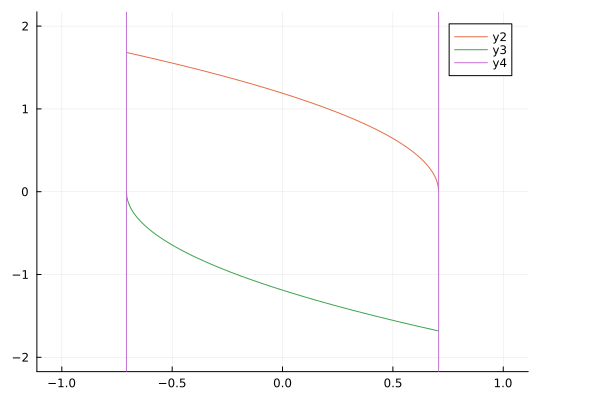

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


In [218]:
plot()
plot_grid!(value_function, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

In [219]:
for x1 in -0.6:0.1:0.6
    x2 = 0.0
    x = [x1, x2]
    ind = HJB.state2ind(grid, x)
    x = HJB.ind2state(grid, ind)
    value_function[ind] = get_value_function(x; maxtime=0.5)
    @show x, value_function[ind]
end

(x, value_function[ind]) = ([-0.6, 0.0], 3.3071067811867123)
(x, value_function[ind]) = ([-0.5, 0.0], 3.207106781186712)
(x, value_function[ind]) = ([-0.3999999999999999, 0.0], 3.1071067811867126)
(x, value_function[ind]) = ([-0.29999999999999993, 0.0], -0.9928932188136174)
(x, value_function[ind]) = ([-0.19999999999999996, 0.0], 2.9071067811867124)
(x, value_function[ind]) = ([-0.09999999999999998, 0.0], 2.8071067811867128)
(x, value_function[ind]) = ([0.0, 0.0], 2.707106781186712)
(x, value_function[ind]) = ([0.20000000000000018, 0.0], 2.507106781186712)
(x, value_function[ind]) = ([0.20000000000000018, 0.0], 2.507106781186712)
(x, value_function[ind]) = ([0.30000000000000004, 0.0], 2.4071067811867124)
(x, value_function[ind]) = ([0.40000000000000013, 0.0], 2.3071067811867123)
(x, value_function[ind]) = ([0.5, 0.0], -0.9502793972483342)
(x, value_function[ind]) = ([0.6000000000000001, 0.0], 2.107106781186712)


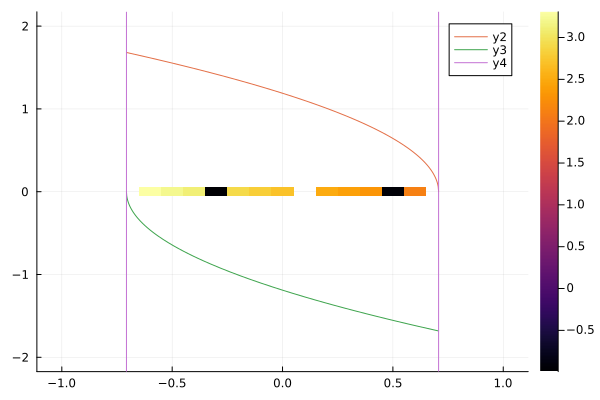

In [220]:
plot()
plot_grid!(value_function, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

In [222]:
for x2 in -0.8:0.1:0.8
    x1 = 0.0
    x = [x1, x2]
    ind = HJB.state2ind(grid, x)
    x = HJB.ind2state(grid, ind)
    value_function[ind] = get_value_function(x; maxtime=0.5)
    @show x, value_function[ind]
end

(x, value_function[ind]) = ([0.0, -0.7999999999999998], 1.3023839273656037)
(x, value_function[ind]) = ([0.0, -0.7], 4.107106781186682)
(x, value_function[ind]) = ([0.0, -0.5999999999999999], 3.9071067811866893)
(x, value_function[ind]) = ([0.0, -0.5], -0.2928932188136043)
(x, value_function[ind]) = ([0.0, -0.3999999999999999], 3.5071067811867023)
(x, value_function[ind]) = ([0.0, -0.2999999999999998], 3.3071067811867065)
(x, value_function[ind]) = ([0.0, -0.19999999999999996], 3.1071067811867095)
(x, value_function[ind]) = ([0.0, -0.09999999999999987], 2.907106781186712)
(x, value_function[ind]) = ([0.0, 0.0], 2.707106781186712)
(x, value_function[ind]) = ([0.0, 0.10000000000000009], -1.4928932188136175)
(x, value_function[ind]) = ([0.0, 0.30000000000000027], 2.1071067811867072)
(x, value_function[ind]) = ([0.0, 0.30000000000000027], 2.1071067811867072)
(x, value_function[ind]) = ([0.0, 0.40000000000000036], 0.04821002805680363)
(x, value_function[ind]) = ([0.0, 0.5], 1.70710678118669

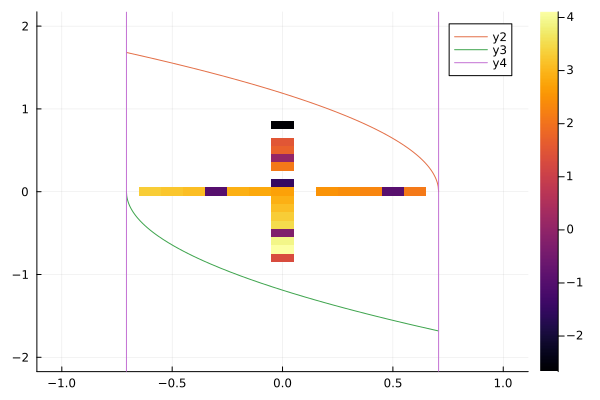

In [223]:
plot()
plot_grid!(value_function, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

(x, value_function[ind]) = ([-0.3999999999999999, 0.10000000000000009], 2.9071067811867115)
(x, value_function[ind]) = ([-0.29999999999999993, 0.10000000000000009], -1.126822897425868)
(x, value_function[ind]) = ([-0.19999999999999996, 0.10000000000000009], 2.3072853120707233)
(x, value_function[ind]) = ([-0.09999999999999998, 0.10000000000000009], -0.7855018573486564)
(x, value_function[ind]) = ([0.0, 0.10000000000000009], 2.507106781186712)
(x, value_function[ind]) = ([0.20000000000000018, 0.10000000000000009], 2.307106781186712)
(x, value_function[ind]) = ([0.20000000000000018, 0.10000000000000009], 2.307106781186712)
(x, value_function[ind]) = ([0.30000000000000004, 0.10000000000000009], 0.4010300677276682)
(x, value_function[ind]) = ([0.40000000000000013, 0.10000000000000009], 2.1071067811867117)


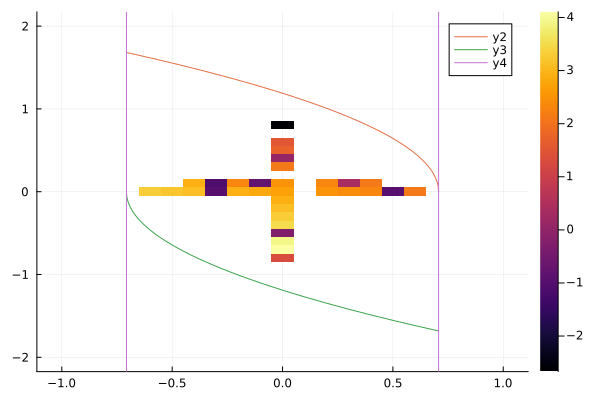

In [224]:
for x1 in -0.4:0.1:0.4
    x2 = 0.1
    x = [x1, x2]
    ind = HJB.state2ind(grid, x)
    x = HJB.ind2state(grid, ind)
    value_function[ind] = get_value_function(x; maxtime=0.5)
    @show x, value_function[ind]
end

plot()
plot_grid!(value_function, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

(x, value_function[ind]) = ([-0.3999999999999999, 0.20000000000000018], 2.70710678118671)
(x, value_function[ind]) = ([-0.29999999999999993, 0.20000000000000018], 2.6071067811867104)
(x, value_function[ind]) = ([-0.19999999999999996, 0.20000000000000018], 2.5071067811867103)
(x, value_function[ind]) = ([-0.09999999999999998, 0.20000000000000018], 2.40710678118671)
(x, value_function[ind]) = ([0.0, 0.20000000000000018], -1.6928932188136145)
(x, value_function[ind]) = ([0.20000000000000018, 0.20000000000000018], 2.10710678118671)
(x, value_function[ind]) = ([0.20000000000000018, 0.20000000000000018], 2.10710678118671)
(x, value_function[ind]) = ([0.30000000000000004, 0.20000000000000018], -1.1188672972274318)
(x, value_function[ind]) = ([0.40000000000000013, 0.20000000000000018], 1.9071067811867097)


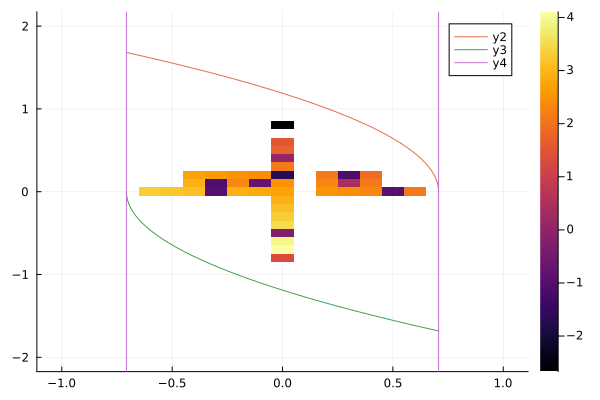

In [225]:
for x1 in -0.4:0.1:0.4
    x2 = 0.15
    x = [x1, x2]
    ind = HJB.state2ind(grid, x)
    x = HJB.ind2state(grid, ind)
    value_function[ind] = get_value_function(x; maxtime=0.5)
    @show x, value_function[ind]
end

plot()
plot_grid!(value_function, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

(x, value_function[ind]) = ([-0.3999999999999999, 0.30000000000000027], 2.5071067811867076)
(x, value_function[ind]) = ([-0.29999999999999993, 0.30000000000000027], 2.4071067811867075)
(x, value_function[ind]) = ([-0.19999999999999996, 0.30000000000000027], 2.3071067811867074)
(x, value_function[ind]) = ([-0.09999999999999998, 0.30000000000000027], 2.2071067811867078)
(x, value_function[ind]) = ([0.0, 0.30000000000000027], 2.1071067811867072)
(x, value_function[ind]) = ([0.20000000000000018, 0.30000000000000027], 1.907106781186707)
(x, value_function[ind]) = ([0.20000000000000018, 0.30000000000000027], 0.32953020305520536)
(x, value_function[ind]) = ([0.30000000000000004, 0.30000000000000027], 1.807106781186707)
(x, value_function[ind]) = ([0.40000000000000013, 0.30000000000000027], 1.7071067811867073)


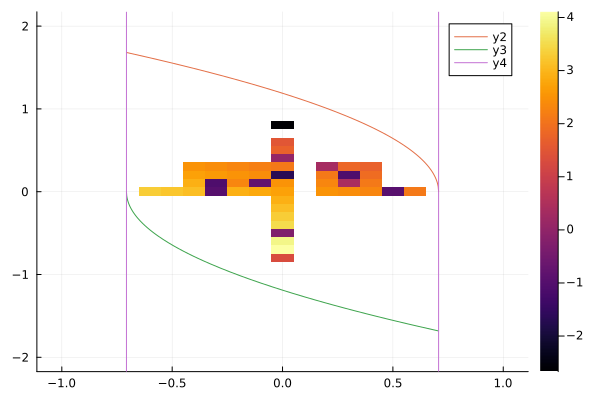

In [226]:
for x1 in -0.4:0.1:0.4
    x2 = 0.2
    x = [x1, x2]
    ind = HJB.state2ind(grid, x)
    x = HJB.ind2state(grid, ind)
    value_function[ind] = get_value_function(x; maxtime=0.5)
    @show x, value_function[ind]
end

plot()
plot_grid!(value_function, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

(x, value_function[ind]) = ([-0.3999999999999999, 0.40000000000000036], 2.3071067811867034)
(x, value_function[ind]) = ([-0.29999999999999993, 0.40000000000000036], 2.2071067811867033)
(x, value_function[ind]) = ([-0.19999999999999996, 0.40000000000000036], 2.1071067811867037)
(x, value_function[ind]) = ([-0.09999999999999998, 0.40000000000000036], 2.0071067811867036)
(x, value_function[ind]) = ([0.0, 0.40000000000000036], 1.9071067811867035)
(x, value_function[ind]) = ([0.20000000000000018, 0.40000000000000036], 1.7071067811867033)
(x, value_function[ind]) = ([0.20000000000000018, 0.40000000000000036], 1.7071067811867033)
(x, value_function[ind]) = ([0.30000000000000004, 0.40000000000000036], 1.6071067811867032)
(x, value_function[ind]) = ([0.40000000000000013, 0.40000000000000036], 1.5071067811867032)


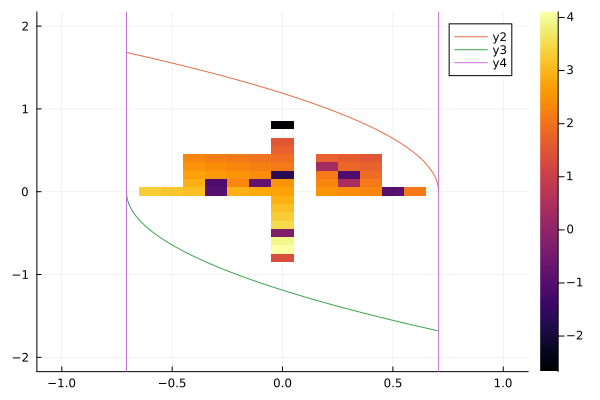

In [227]:
for x1 in -0.4:0.1:0.4
    x2 = 0.4
    x = [x1, x2]
    ind = HJB.state2ind(grid, x)
    x = HJB.ind2state(grid, ind)
    value_function[ind] = get_value_function(x; maxtime=0.5)
    @show x, value_function[ind]
end

plot()
plot_grid!(value_function, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

(x, value_function[ind]) = ([-0.3999999999999999, 0.5], 2.1071067811866993)
(x, value_function[ind]) = ([-0.29999999999999993, 0.5], 2.0071067811866996)
(x, value_function[ind]) = ([-0.19999999999999996, 0.5], 1.907106781186699)
(x, value_function[ind]) = ([-0.09999999999999998, 0.5], -2.192893218813602)
(x, value_function[ind]) = ([0.0, 0.5], 1.7071067811866993)
(x, value_function[ind]) = ([0.20000000000000018, 0.5], -2.492893218813602)
(x, value_function[ind]) = ([0.20000000000000018, 0.5], 1.5071067811866987)
(x, value_function[ind]) = ([0.30000000000000004, 0.5], 1.407106781186699)


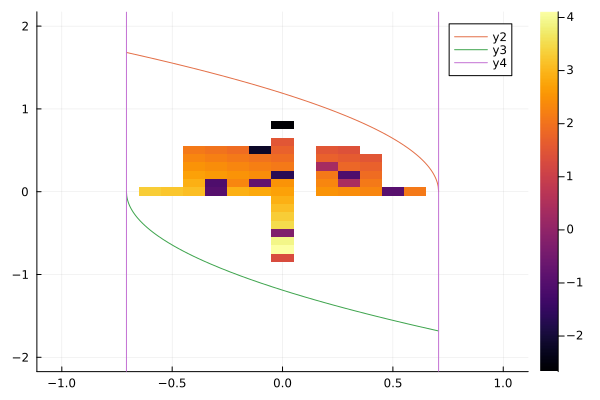

In [228]:
for x1 in -0.4:0.1:0.3
    x2 = 0.5
    x = [x1, x2]
    ind = HJB.state2ind(grid, x)
    x = HJB.ind2state(grid, ind)
    value_function[ind] = get_value_function(x; maxtime=0.5)
    @show x, value_function[ind]
end

plot()
plot_grid!(value_function, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

(x, value_function[ind]) = ([-0.6, 1.0], 1.307106781186659)
(x, value_function[ind]) = ([-0.5, 1.0], 1.207106781186659)
(x, value_function[ind]) = ([-0.3999999999999999, 1.0], 1.1071067811866588)
(x, value_function[ind]) = ([-0.29999999999999993, 1.0], 1.0071067811866588)
(x, value_function[ind]) = ([-0.19999999999999996, 1.0], 0.9071067811866588)
(x, value_function[ind]) = ([-0.09999999999999998, 1.0], 0.807106781186659)
(x, value_function[ind]) = ([0.0, 1.0], -1.433996465683817)
(x, value_function[ind]) = ([0.20000000000000018, 1.0], 0.5071067811866584)
(x, value_function[ind]) = ([0.20000000000000018, 1.0], 0.5071067811866584)
(x, value_function[ind]) = ([0.30000000000000004, 1.0], 0.40710678118665883)
(x, value_function[ind]) = ([0.40000000000000013, 1.0], 0.30710678118665874)
(x, value_function[ind]) = ([0.5, 1.0], 0.20193810831706482)
(x, value_function[ind]) = ([0.6000000000000001, 1.0], -3.4627771313042746)


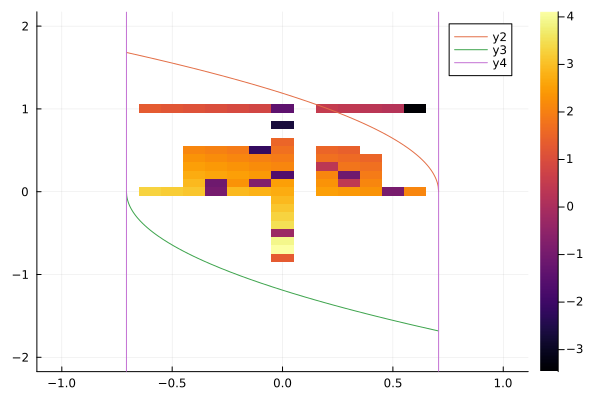

In [231]:
for x1 in -0.6:0.1:0.6
    x2 = 1.0
    x = [x1, x2]
    ind = HJB.state2ind(grid, x)
    x = HJB.ind2state(grid, ind)
    value_function[ind] = get_value_function(x; maxtime=0.5)
    @show x, value_function[ind]
end

plot()
plot_grid!(value_function, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

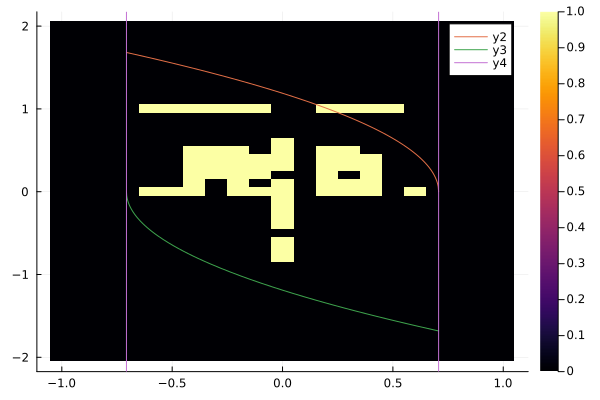

In [232]:
plot()
plot_grid!(value_function .>= 0.0, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

In [229]:
x = [0.4, 0.975]
ind = HJB.state2ind(grid, x)
x = HJB.ind2state(grid,ind)

2-element SVector{2, Float64} with indices SOneTo(2):
 0.40000000000000013
 1.0

In [230]:
value_function[ind] = get_value_function(x; maxtime=1.0)

0.33988573006163497

In [248]:
for i in 1:100
    x = randn(2)
    ind = HJB.state2ind(grid, x)
    if ind in HJB.DomainIndices(grid)
        x = HJB.ind2state(grid, ind)
        value_function[ind] = get_value_function(x; maxtime=0.5)
        @show x, value_function[ind]
    end
end


(x, value_function[ind]) = ([-0.09999999999999998, 0.7000000000000002], 1.4071067811866862)
(x, value_function[ind]) = ([-0.29999999999999993, -1.5], 6.0071067811867085)
(x, value_function[ind]) = ([-0.09999999999999998, -0.09999999999999987], 3.0071067811867125)
(x, value_function[ind]) = ([-0.5, 0.20000000000000018], 2.80710678118671)
(x, value_function[ind]) = ([-0.5, -1.1], 5.407106781186664)
(x, value_function[ind]) = ([-0.8, -1.6], 6.707106781186721)
(x, value_function[ind]) = ([-0.3999999999999999, -0.7], 4.507106781186683)
(x, value_function[ind]) = ([-0.09999999999999998, 0.0], 2.8071067811867128)
(x, value_function[ind]) = ([-1.0, -0.7999999999999998], 1.3071067811864165)
(x, value_function[ind]) = ([0.0, 1.1], 0.5071067811866263)
(x, value_function[ind]) = ([0.30000000000000004, -0.8999999999999999], 4.207106781186664)
(x, value_function[ind]) = ([0.7000000000000002, -0.5999999999999999], 3.20710678118669)
(x, value_function[ind]) = ([0.8, 0.5], 0.9071067811866992)
(x, value

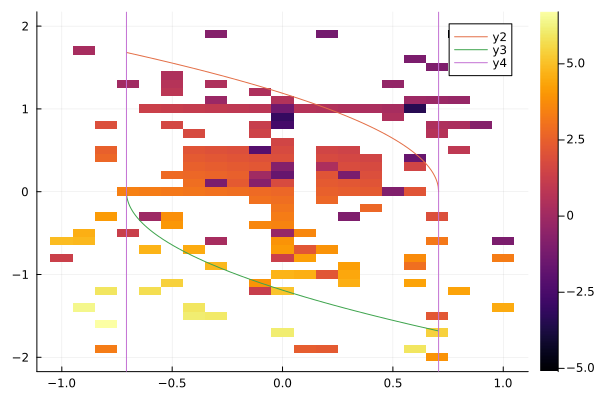

In [249]:

plot()
plot_grid!(value_function, grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

In [250]:
categorize(v; eps=0) = isnan(v) ? 0 : (v >= eps ? 1 : -1 )

categorize (generic function with 1 method)

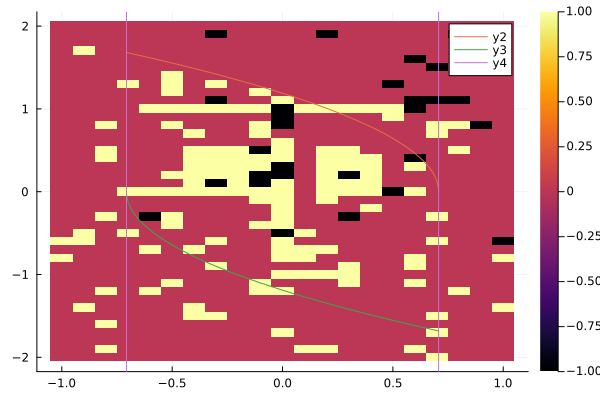

In [251]:

plot()
plot_grid!(categorize.(value_function), grid)
plot!(p-> sqrt(2 * 1 * (sqrt(2)/2 - p)), -sqrt(2)/2, sqrt(2)/2)
plot!(p -> -sqrt(2 * 1 * (p + sqrt(2)/2 )), -sqrt(2)/2, sqrt(2)/2)
vline!([-sqrt(2)/2, sqrt(2)/2])

In [243]:
@time get_value_function(randn(2))

  1.112158 seconds (6.63 M allocations: 341.697 MiB, 4.11% gc time)


5.667346631048511